# Sentiment Classification for Movie Review Dataset (English)

본 핸즈온에서는 영화 리뷰에 대한 감정(0: 부정, 1: 긍정)을 요약한 Stanford Sentiment Treebank (SST) 데이터셋으로 AutoGluon 훈련을 수행합니다.

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
np.random.seed(123)

<br>

## 1. Data preparation and Training

In [2]:
save_path = 'ag-01-sentiment-classifcation-eng'
!rm -rf $save_path

샘플 데이터셋을 다운로드합니다. parquet와 csv를 지원하며, 원격에 저장된 데이터셋을 다운로드하거나 로컬에서 데이터셋을 직접 로드할 수 있습니다.

In [3]:
from autogluon.core.utils.loaders.load_pd import load
train_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/train.parquet')
test_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/dev.parquet')
subsample_size = 1000  # subsample data for faster demo, try setting this to larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
train_data.head(5)

,sentence,label
43787,very pleasing at its best moments,1
16159,", american chai is enough to make you put away...",0
59015,too much like an infomercial for ram dass 's l...,0
5108,a stirring visual sequence,1
67052,cool visual backmasking,1


훈련 지정 시 좀 더 세부적인 하이퍼파라메터 설정이 필요하다면, 사전 정의된 preset을 사용하시면 편리합니다. TextPredictor는 사전 훈련된 BERT, RoBERT, ELECTRA가 내장되어 있으며, 한국어를 비롯한 다국어에 대한 훈련이 필요하면 `multi_cased_bert_base_fuse_late` preset을 사용하시면 됩니다.

In [8]:
from autogluon.text import TextPredictor, ag_text_presets, list_presets
list_presets()

{'simple_presets': ['default',
  'lower_quality_fast_train',
  'medium_quality_faster_train',
  'best_quality'],
 'advanced_presets': ['electra_small_fuse_late',
  'electra_base_fuse_late',
  'electra_large_fuse_late',
  'roberta_base_fuse_late',
  'multi_cased_bert_base_fuse_late',
  'electra_base_fuse_early',
  'electra_base_all_text']}

INFO:root:NumPy-shape semantics has been activated in your code. This is required for creating and manipulating scalar and zero-size tensors, which were not supported in MXNet before, as in the official NumPy library. Please DO NOT manually deactivate this semantics while using `mxnet.numpy` and `mxnet.numpy_extension` modules.
INFO:autogluon.text.text_prediction.mx.models:The GluonNLP V0 backend is used. We will use 8 cpus and 1 gpus to train each trial.


All Logs will be saved to /home/ec2-user/SageMaker/autogluon-hol/2.nlp/ag-01-sentiment-classifcation-eng/task0/training.log


INFO:root:Fitting and transforming the train data...
INFO:root:Done! Preprocessor saved to /home/ec2-user/SageMaker/autogluon-hol/2.nlp/ag-01-sentiment-classifcation-eng/task0/preprocessor.pkl
INFO:root:Process dev set...
INFO:root:Done!
INFO:root:Max length for chunking text: 64, Stochastic chunk: Train-False/Test-False, Test #repeat: 1.
INFO:root:#Total Params/Fixed Params=108990466/0
Level 15:root:Using gradient accumulation. Global batch size = 128
INFO:root:Local training results will be saved to /home/ec2-user/SageMaker/autogluon-hol/2.nlp/ag-01-sentiment-classifcation-eng/task0/results_local.jsonl.
Level 15:root:[Iter 1/70, Epoch 0] train loss=9.45e-01, gnorm=8.10e+00, lr=1.43e-05, #samples processed=128, #sample per second=73.50. ETA=2.00min
Level 15:root:[Iter 2/70, Epoch 0] train loss=7.89e-01, gnorm=1.14e+01, lr=2.86e-05, #samples processed=128, #sample per second=166.48. ETA=1.42min
Level 25:root:[Iter 2/70, Epoch 0] valid f1=7.2026e-01, mcc=1.3177e-02, roc_auc=4.2102e-01, 

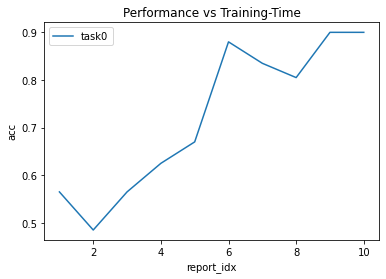

INFO:root:Training completed. Auto-saving to "ag-01-sentiment-classifcation-eng/". For loading the model, you can use `predictor = TextPredictor.load("ag-01-sentiment-classifcation-eng/")`


In [4]:
predictor = TextPredictor(label='label', eval_metric='acc', path=save_path)
predictor.fit(train_data, time_limit=60)

<br>

## 2. Evaluation and Prediction

### Evaluation
`predictor.evaluation()`를 사용하여 평가를 쉽게 수행할 수 있으며, F1 score 등의 추가 metric도 지정 가능합니다.

In [6]:
test_score = predictor.evaluate(test_data, metrics=['acc', 'f1'])
print(test_score)

{'acc': 0.8876146788990825, 'f1': 0.8844339622641509}


### Prediction
`predictor.predict()`으로 예측을 수행할 수 있습니다.

In [7]:
sentence1 = "it's a charming and often affecting journey."
sentence2 = "It's slow, very, very, very slow."
predictions = predictor.predict({'sentence': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Predicted Sentiment":', predictions[0])
print('"Sentence":', sentence2, '"Predicted Sentiment":', predictions[1])

"Sentence": it's a charming and often affecting journey. "Predicted Sentiment": 1
"Sentence": It's slow, very, very, very slow. "Predicted Sentiment": 0


In [9]:
probs = predictor.predict_proba({'sentence': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Predicted Class-Probabilities":', probs[0])
print('"Sentence":', sentence2, '"Predicted Class-Probabilities":', probs[1])

"Sentence": it's a charming and often affecting journey. "Predicted Class-Probabilities": 0    0.017304
1    0.919805
Name: 0, dtype: float32
"Sentence": It's slow, very, very, very slow. "Predicted Class-Probabilities": 0    0.982696
1    0.080195
Name: 1, dtype: float32


전체 데이터셋에 대해 추론을 수행할 수도 있습니다.

In [ ]:
# test_predictions = predictor.predict(test_data)
# test_predictions.head()

### Save and Load

predictor는 `fit()` 함수로 모델 훈련 시에 자동으로 모델을 저장하며, `load()` 함수를 통해 재로드할 수 있습니다. 물론 `save()` 함수로 모델을 저장하는 것도 가능합니다.

In [10]:
loaded_predictor = TextPredictor.load(save_path)
loaded_predictor.predict_proba({'sentence': [sentence1, sentence2]})

,0,1
0,0.017304,0.982696
1,0.919805,0.080195


### Extract Embeddings
훈련된 predictor를 사용하여 임베딩 벡터에 매핑하는 임베딩을 추출할 수도 있습니다.

In [11]:
embeddings = predictor.extract_embedding(test_data)
print(embeddings)

[[-2.8687883e-02  5.3326314e-04  1.1144626e-01 ... -3.7803152e-01
   5.5846143e-01  4.1371959e-01]
 [-4.8518036e-03  5.6912249e-01  2.4588600e-01 ...  1.5590957e-01
   2.4007417e-01  1.7444690e-01]
 [ 2.2508471e-01  2.5632674e-01  4.8000675e-01 ... -1.9713846e-01
   5.1324850e-01  4.4378969e-01]
 ...
 [ 3.3065796e-01  2.1951196e-01  4.5575449e-01 ... -1.0022802e-01
   2.1053088e-01  4.0342742e-01]
 [ 6.7251277e-01  4.0480185e-01  7.1099810e-02 ...  1.5235341e-01
   1.1263622e-01  1.4860499e-01]
 [-1.4207645e-01  4.3629059e-01  2.9361528e-01 ... -3.1910279e-01
   1.4163065e-01  2.7840173e-01]]


TSNE를 사용하여 추출된 임베딩을 시각화합니다. 두 레이블에 해당하는 두 개의 클러스터가 잘 분포해 있음을 확인할 수 있습니다.

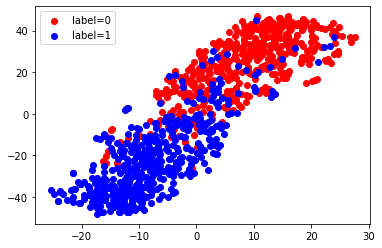

In [12]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=123).fit_transform(embeddings)
for val, color in [(0, 'red'), (1, 'blue')]:
    idx = (test_data['label'].to_numpy() == val).nonzero()
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
plt.legend(loc='best')